In [3]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import os
import re
import random
import glob
from sklearn.model_selection import train_test_split

In [4]:
def set_seed(n_seed):
    np.random.seed(n_seed)
    random.seed(n_seed)
    torch.manual_seed(n_seed)
    torch.cuda.manual_seed(n_seed)
    torch.backends.cudnn.deterministic = True

In [5]:
DIR_INPUT = r'../data/raw/'
DIR_PROCESSED_DATA = r'../data/processed/'
DIR_TRAIN = DIR_INPUT + 'train/'
DIR_TEST = DIR_INPUT + 'test/'
print(os.getcwd())

C:\Users\Vadim\Desktop\folders\For myself\Python\ProjectsDVC\GlobalWheatDetection\Global Wheat\notebooks


In [6]:
train_df = pd.read_csv(f"{DIR_PROCESSED_DATA}train.csv")
train_df.head()
# len(train_df.image_id.unique())

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [7]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

In [8]:
def expend_box(obj):
    temple = np.array(re.findall("([0-9]+[.]?[0-9]*)", obj))
    if len(temple) == 0:
        temple = [-1, -1, -1, -1]
    return temple

In [9]:
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda obj: expend_box(obj)))

In [10]:
train_df.head(5)

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [11]:
train_df['x'] = train_df['x'].astype(np.float64)
train_df['y'] = train_df['y'].astype(np.float64)
train_df['w'] = train_df['w'].astype(np.float64)
train_df['h'] = train_df['h'].astype(np.float64)

In [12]:
train_df.drop(columns=['bbox'], inplace=True)

In [ ]:
# train_df = train_df.sample(frac=True).reset_index(drop=True)
# train_df.head()
# len(train_df.image_id.unique())

In [13]:
imgs_id = train_df['image_id'].unique()
perct = 0.2
ids = int(len(imgs_id) * (1 - perct))
print(ids)
train_ids = imgs_id[:ids]
valid_ids = imgs_id[ids:]
print(len(imgs_id), len(valid_ids), len(train_ids))

2698
3373 675 2698


In [14]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [15]:
len(train_df.image_id.unique()), len(valid_df.image_id.unique())

(2698, 675)

In [17]:
class DatasetWheatTrain(Dataset):
    
    def __init__(self, data_frame, dir_imgs, transforms=None):
        super(Dataset).__init__()
        
        self.imgs_id = data_frame['image_id'].unique()
        self.df = data_frame
        self.dir_imgs = dir_imgs
#         self.list_imgs = sorted(list(glob.glob(self.dir_imgs + '*.jpg')))
        self.transforms = transforms
        
    
    def __getitem__(self, idx):
        
        image_id = self.imgs_id[idx]
#         print(image_id)
        records_img = self.df[self.df['image_id'] == image_id]
#         print(records_img)
        
        image = cv2.imread(f"{self.dir_imgs}/{image_id}.jpg", cv2.IMREAD_COLOR)
#         print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image/=255.0
#         print(len(image[0][0]))
#         print(image)
        boxes = records_img[['x', 'y', 'w', 'h']].values
#         print(self.df)
#         print()
#         print(boxes)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         print(boxes[:, 3])
#         print('abcd')
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
#         print(boxes[:, 3])
#         print()
#         print(boxes)
    
        area = torch.as_tensor((boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]))
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = torch.ones((records_img.shape[0],), dtype=torch.int64)
        
        iscrowd = torch.zeros((records_img.shape[0],),dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx]) # ???
        target['area'] = area
        target['iscrowd'] = iscrowd
#         print(target['boxes'].dtype)
        
        if self.transforms is not None:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels,
            }
            
            sample = self.transforms(**sample)
#             print(sample['bboxes'].dtype)
            
            image = sample['image']
#             print(image.dtype)
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
#         print(target['boxes'])
#         print(target['boxes'].dtype)
#         print(target['labels'].dtype)
        #print(target['area'].dtype)
        #print(target['iscrowd'].dtype)
        return (image, target)
    
    def __len__(self):
        return self.imgs_id.shape[0]

In [30]:
class DatasetWheatTest(Dataset):
    
    def __init__(self, data_frame, dir_imgs, transforms=None):
        super(Dataset).__init__()
        
        self.imgs_id = data_frame['image_id'].unique()
        self.df = data_frame
        self.dir_imgs = dir_imgs
        self.transforms = transforms
        
    
    def __getitem__(self, idx):
        
        image_id = self.imgs_id[idx]
        records_img = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f"{self.dir_imgs}/{image_id}.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image/=255.0
        
        if self.transforms is not None:
            sample = {
                'image': image,
            }
            
            sample = self.transforms(**sample)
            
            image = sample['image']

        return image
    
    def __len__(self):
        return self.imgs_id.shape[0]

In [31]:
def transform_train():
    return A.Compose([
        A.Flip(p=1.0),
        ToTensorV2(p=1.0)], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']}) 

def transform_test():
    return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [32]:
train_dataset = DatasetWheatTrain(train_df, DIR_TRAIN, transforms=transform_train())
valid_dataset = DatasetWheatTrain(valid_df, DIR_TRAIN, transforms=transform_test())

In [33]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [34]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [35]:
num_classes = 2 # objects + background
model = get_model(num_classes)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Vadim/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [36]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [37]:
def vizualizate(img_tensor, target):
    fig, ax = plt.subplots(1,1, figsize=(16,10))
#     print(img_tensor.shape)
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
#     print(img.shape)
#     print(img)
    for box in target['boxes'].cpu().detach().numpy().astype(np.int32):
        xmin, ymin, xmax, ymax = box
#         print(xmin, ymin, xmax, ymax)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 3)
        
    ax.set_axis_off()
    ax.imshow(img)

In [38]:
train_batch_size = 12
valid_batch_size = 6

In [39]:
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False, collate_fn=collate_fn)

In [40]:
images, targets = next(iter(train_loader));
images = [image.to(device) for image in images];
targets = [{key: value.to(device) for key, value in target.items()} for target in  targets];

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


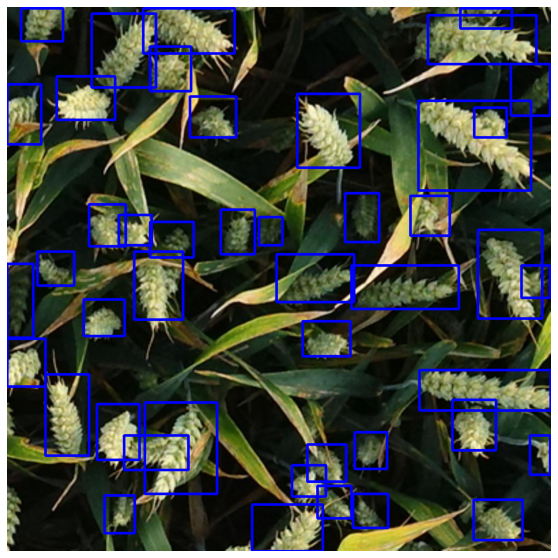

In [41]:
vizualizate(images[2], targets[2])

# Train model

In [42]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.05, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 15
num_model = 1

In [43]:
loss_epochs = []
loss_iter = []
loss_iter_epochs = []

# Train model

In [44]:
model.train()
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    iteretions = 0
    for imgs, annotations in tqdm(train_loader):
        iteretions+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{key: value.to(device) for key, value in annotation.items()} for annotation in annotations]
        
        prediction = model(imgs, annotations)
        
        losses = sum(loss for loss in prediction.values())
        epoch_loss += losses.item()
        
        loss_iter.append(losses.item()/iteretions)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if iteretions % 40 == 0:
            print(f'For iteretion {iteretions} epoch {epoch + 1} loss is {losses.item()}')
    
    print(f'For epoch {epoch + 1} loss is {epoch_loss/iteretions}')
    loss_epochs.append(epoch_loss/iteretions)
    loss_iter_epochs.append(loss_iter)
        
    if lr_scheduler is not None:
        lr_scheduler.step() 
    
    
    if (epoch % 3 == 0):
        name_model = f'fasterrcnn_model_{num_model}.pth'
        torch.save(model.state_dict(), name_model)
        print(f'Model {name_model} has been saved')
        print('\n')
        num_model+=1

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Validation

In [ ]:
model.eval()
iteration = 0
for imgs, annotations in valid_loader:
    iteration+=1
    imgs = [img.to(device) for img in imgs]
    annotations = [{key:value.to(device) for key, value in annotation.items()} for annotation in annotations]
    
    with torch.no_grad():
        prediction = model(imgs, annotations)
    losses = sum(loss for loss in prediction.values())

print(losses/iteration)

In [ ]:
valid_imgs, annotations_valid = next(iter(valid_loader))
valid_imgs = [valid_img.to(device) for valid_img in valid_imgs]
annotations_valid = [{key: value.to(device) for key, value in annotation_valid.items()} for annotation_valid in annotations_valid]

In [ ]:
model.eval()
test_device = torch.device('cpu')
model = model.to(device)
outputs_imgs = model(valid_imgs)
outputs = [{key:value for key, value in out.items()} for out in outputs_imgs]

In [ ]:
numb_img = 5
vizualizate(images[numb_img], outputs[numb_img])

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_global_whea_detect.pth')

# Inference model

In [ ]:
test_df = pd.read_csv('../input/global-wheat-detection/sample_submission.csv')

In [ ]:
test_dataset = DatasetWheatTest(test_df, DIR_TEST,transforms=transform_test())

In [ ]:
test_loader = DataLoader(test_dataset,batch_size=4, shuffle=False, num_workers=4, drop_last=False,collate_fn=collate_fn)

In [ ]:
def format_submit_string(boxes, scores):
    submit_string = []
    for i in zip(boxes, scores):
        submit_string.append("{0:.4f} {1} {2} {3} {4}".format(i[0], i[1][0], i[1][1], i[1][2], i[1][3]))
        
    return "".join(submit_string)

In [ ]:
threshold_detect = 0.5
result = []
for imgs, annotations in test_loader:
    imgs = [img.to(device) for img in imgs]
    
    with torch.no_grad():
        prediction = model(imgs)
        
    for i, image in enumerate(imgs):
        boxes = prediction[i]['boxes'].data.cpu().numpy()
        scores = prediction[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores>=threshold_detect].as_type(np.float32)
        scores = scores[scores>=threshold_detect]
        img_id = image[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        str_result = {
            'image_id': img_id ,
            'PredictionString':format_submit_string(boxes, scores),
        }
        
        result.append(str_result)